# CS Recon using TV-Minimization

<ipython-input-15-07740176d0a6>:37: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_data = img.get_data()


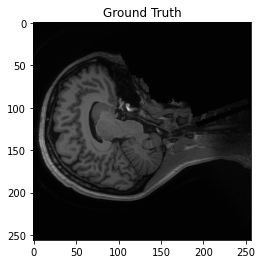

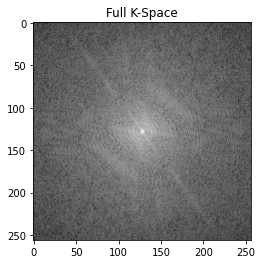

In [15]:
import sys
sys.path.insert(0,'../../common/')
import bart

import subsample
import pathlib
import h5py
import numpy as np
from common import utils
from matplotlib import pyplot as plt
import torch
try:
    import nibabel as nib
except:
    ! pip install nibabel 
    import nibabel as nib

from data import transforms, mri_data

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])

def data_transform(kspace, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
    return masked_kspace
'''
dataset = mri_data.SliceData(
    root=pathlib.Path('dataset/'),
    transform=data_transform,
    challenge='singlecoil'
)
'''
img = nib.load('/home/ubuntu/Downloads/dataset/singlecoil_val.nii')
img_data = img.get_data()
img_data_arr = np.asarray(img_data)
test_1=img_data_arr[:,:,88+9]
plt.imshow(test_1,cmap='gray')
plt.title('Ground Truth')
plt.figure()
data = test_1.astype(np.float32)
img_torch = torch.from_numpy(data)
fft_img_torch = torch.fft.fft2(img_torch,norm="ortho")
fft_img_torch = torch.fft.fftshift(fft_img_torch) 
plt.imshow(20*np.log(torch.abs(fft_img_torch)),cmap='gray')
plt.title('Full K-Space')
img_data_arr = img_data_arr.astype(np.float32)
img_data_torch = torch.from_numpy(img_data_arr)

### Evaluate k-space based tv minimization

In [16]:
kspace = np.zeros(img_data_torch.shape,dtype='complex')
kspace = torch.from_numpy(kspace)
for i in range(img_data_torch.shape[2]):
    fft_img = torch.fft.fft2(img_data_torch[:,:,i],norm="ortho")
    kspace[:,:,i] = torch.fft.fftshift(fft_img ) 


<ipython-input-38-502c78e28e40>:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(20*np.log(torch.abs(masked_kspace_slice)),cmap='gray')


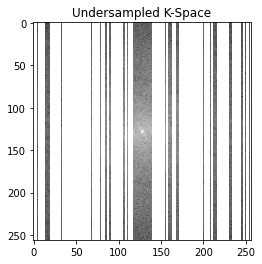

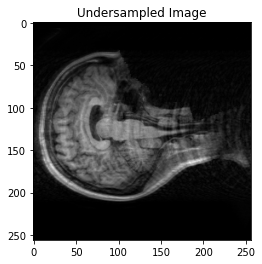

In [38]:
mask_func = subsample.RandomMaskFunc(center_fractions=[0.09, 0.09], accelerations=[2, 2])    
masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
masked_kspace_slice = masked_kspace[:,:,88-5]
plt.imshow(20*np.log(torch.abs(masked_kspace_slice)),cmap='gray')
plt.title('Undersampled K-Space')
plt.figure()
ksp_slice = torch.fft.ifft2(torch.fft.ifftshift(masked_kspace_slice))
plt.imshow(torch.abs(ksp_slice),cmap='gray')
plt.title('Undersampled Image')

masked_kspace_slice = masked_kspace_slice.detach().cpu().numpy()
sens_maps = bart.bart(1, f'ecalib -d0 -m1', masked_kspace_slice)
pred = bart.bart(1, f'pics -d0 -S -R T:7:0:{0.01} -i {100}', masked_kspace_slice, sens_maps)

ksp_slice = ksp_slice.detach().cpu().numpy()

#pred = torch.from_numpy(np.abs(pred[0]))

Text(0.5, 1.0, 'Reconstructed Image')

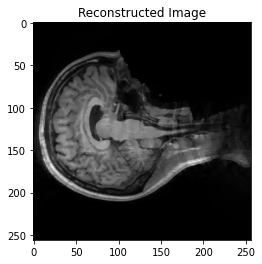

In [39]:
#pred=transforms.center_crop(np.fft.ifftshift(pred), (smallest_height, smallest_width))
pred = np.fft.ifftshift(pred)
plt.imshow(np.abs(pred),cmap='gray')
plt.title('Reconstructed Image')

### Compute metrics

In [40]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import compare_ssim

# normalization before computing the scores
im2 = np.copy(np.abs(ksp_slice))
im1 = test_1
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]
(score, diff) = compare_ssim(im1,im2, full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im2.max()-im2.min())
print(f'Compressed Sensed Image: SSIM = {ms_ssim_:.3f}, PSNR = {psnr1:.3f}')

# normalization before computing the scores
im2 = np.copy(np.abs(pred))
im1 = test_1
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]
(score, diff) = compare_ssim(im1,im2,full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im2.max()-im2.min())
print(f'Reconstructed Image: SSIM = {ms_ssim_:.3f}, PSNR = {psnr1:.3f}')

Compressed Sensed Image: SSIM = 0.767, PSNR = 21.674
Reconstructed Image: SSIM = 0.784, PSNR = 21.756


<ipython-input-40-e274ee4cc74e>:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im1,im2, full=True)
<ipython-input-40-e274ee4cc74e>:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im1,im2,full=True)


In [32]:
from pytorch_msssim import ms_ssim
dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]

In [33]:
ms_ssim_

0.7858022

### Laplacian Sampling to improve SSIM

Img          254.99998 0.0
Original Lap 646.0198 -730.3072
Scaled Lap   100.0 -113.04719
SharpImg     350.7419 -106.224754
SharpImg abs 350.7419 3.7699938e-05
SharpImg after scaling 254.99998 2.7408996e-05


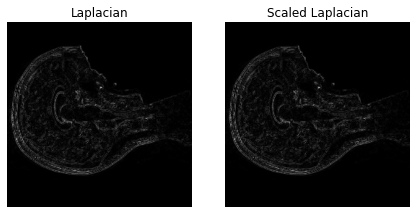

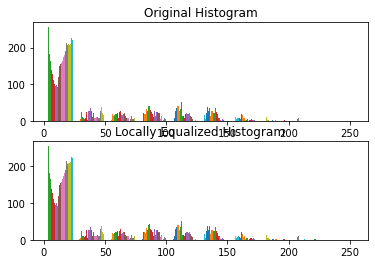

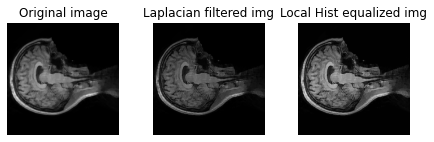

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.misc
import scipy.ndimage.filters
import cv2

#Function for plotting abs:
pic_n       = 1
def show_abs(I, plot_title):
    plt.title(plot_title)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(abs(I), cm.gray)

#Reading of the image into numpy array:
A0           = np.copy(np.abs(pred))
A0          -= np.amin(A0)#map values to the (0, 255) range
A0          *= 255.0/np.amax(A0)
print('Img         ', np.amax(A0), np.amin(A0))
#>>> Img          255.0 0.0

#Kernel for negative Laplacian
kernel      = np.ones((3,3))*(-1)
kernel[1,1] = 8

#Convolution of the image with the kernel:
Lap        = scipy.ndimage.filters.convolve(A0, kernel)

#Laplacian now has negative values
print('Original Lap', np.amax(Lap), np.amin(Lap))
#>>> Original Lap 1151.0 -1166.0

#Map Laplacian to some new range:
Laps        = Lap*100.0/np.amax(Lap) #Sharpening factor!
print('Scaled Lap  ', np.amax(Laps), np.amin(Laps))
#>>> Scaled Lap   100.0 -101.303

plt.figure(pic_n)
pic_n += 1
plt.subplot(1,2,1)
show_abs(Lap, 'Laplacian')
plt.subplot(1,2,2)
show_abs(Laps, 'Scaled Laplacian')

A           = A0 + Laps #Add negative Laplacian to the original image

print('SharpImg    ', np.amax(A), np.amin(A))
#>>> SharpImg     350.917 -81.06

A = abs(A) #Get rid of negative values
print('SharpImg abs', np.amax(A), np.amin(A))

A           *= 255.0/np.amax(A)
print('SharpImg after scaling', np.amax(A), np.amin(A))
#>>> SharpImg abs 350.917 0.0

# Local Histogram Equalization with OpenCV:
A_cv2       = A
A_cv2       = A_cv2.astype(np.uint8)

tile_s0     = 4
tile_s1     = 4

clahe       = cv2.createCLAHE(clipLimit=1, tileGridSize=(tile_s0,tile_s1))
A_cv2       = clahe.apply(A_cv2)

plt.figure(pic_n)
pic_n += 1
plt.subplot(2,1,1)
plt.hist(A_cv2)
plt.title('Original Histogram')
plt.subplot(2,1,2)
plt.hist(A_cv2)
plt.title('Locally Equalized Histogram')

plt.figure(pic_n)
pic_n += 1
plt.subplot(1,3,1)
show_abs(A0, 'Original image')
plt.subplot(1,3,2)
show_abs(A, 'Laplacian filtered img')
plt.subplot(1,3,3)
show_abs(A_cv2, 'Local Hist equalized img')
plt.show()

In [12]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import compare_ssim

# normalization before computing the scores
im2 = np.copy(np.abs(ksp_slice))
im1 = test_1
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

(score, diff) = compare_ssim(im1,im2, full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im2.max()-im2.min())
print(f'Compressed Sensed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')

# normalization before computing the scores
im2 = np.copy(A_cv2)
im1 = test_1
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

(score, diff) = compare_ssim(im1,im2,full=True)
psnr1 = peak_signal_noise_ratio(im1,im2,data_range=im1.max()-im1.min())
print(f'Reconstructed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')

Compressed Sensed Image: SSIM = 0.681, PSNR = 21.237
Reconstructed Image: SSIM = 0.459, PSNR = 24.642


<ipython-input-12-8c0d4869becb>:11: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im1,im2, full=True)
<ipython-input-12-8c0d4869becb>:22: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(im1,im2,full=True)


### Visualise Outputs

(-0.5, 255.5, 255.5, -0.5)

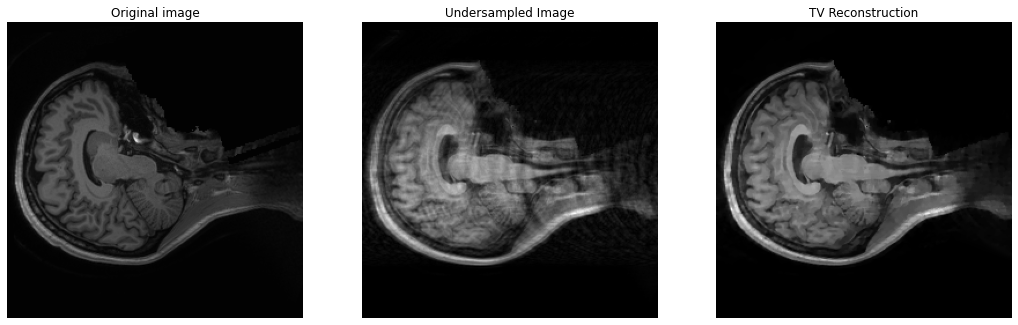

In [13]:
fig = plt.figure(figsize = (18,16)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(test_1,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(np.abs(ksp_slice),cmap='gray')
ax2.set_title( "Undersampled Image") 
ax2.axis('off') 

ax3 = fig.add_subplot(133)
ax3.imshow(np.abs(pred),cmap='gray')
ax3.set_title( "TV Reconstruction" ) 
ax3.axis('off')